< cv2.dnn.Net 0x103ff2970>


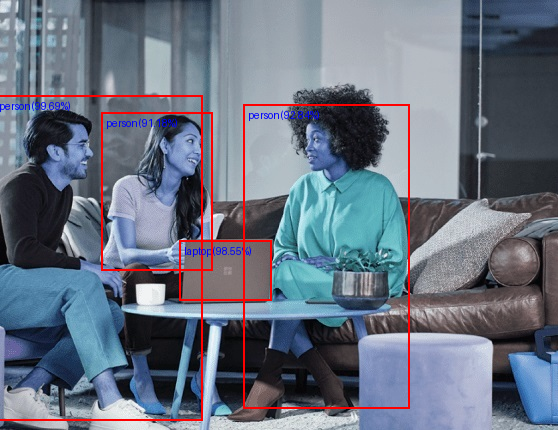

In [1]:
import cv2
from PIL import Image, ImageDraw
import numpy as np

weights_path = "yolo/yolov3.weights"
config_path = "yolo/yolov3.cfg"
names_path = "yolo/coco.names"

with open(names_path, 'r', encoding='utf-8') as file:
    label_list = file.read().strip().split("\n")

net = cv2.dnn.readNet(weights_path, config_path)
print(net)

def detect_object(image_array):

    image = Image.fromarray(image_array.copy())
    draw = ImageDraw.Draw(image)

    height, width = image_array.shape[:2]
    blob = cv2.dnn.blobFromImage(image_array, 1/255.0, (416, 416),swapRB=True, crop=False)
    net.setInput(blob)
    layer_name_list = net.getLayerNames()
    out_layer_list = net.getUnconnectedOutLayersNames()
    detection_list = net.forward(out_layer_list)

    bounding_box_list = list()
    confidence_list = list()
    label_index_list = list()

    for prediction_list in detection_list:
        # yolo82, yolo94, yolo 106
        for prediction in prediction_list:
            score_list = prediction[5:]
            label_index = np.argmax(score_list)
            confidence = score_list[label_index]
            if confidence > 0.9:
                bounding_box = prediction[:4] * np.array([width, height, width, height])
                center_x, center_y, w, h = bounding_box.astype('int')
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                # print(x, y, w, h)

                bounding_box_list.append([x, y, w, h])
                confidence_list.append(confidence)
                label_index_list.append(label_index)

                # draw.rectangle([(x, y), (x + w, y + h)], outline='red', width=2)

    extracted_index_list = cv2.dnn.NMSBoxes(bounding_box_list, confidence_list, 0.5, 0.4)

    for extracted_index in extracted_index_list:
        x, y, w, h = bounding_box_list[extracted_index]
        confidence = confidence_list[extracted_index]
        label_index = label_index_list[extracted_index]
        label_text = label_list[label_index]

        draw.rectangle([(x, y), (x + w, y + h)], outline="red", width=2)
        draw.text((x + 5, y + 5), "{}({:.2f}%)".format(label_text, confidence * 100), fill="blue")

    return image

test_image = cv2.imread("/Users/yubin/Downloads/ImageTaggingSample1-fd324157.jpg")
detect_object(test_image)